# This notebook contains my code from Will Tipton's "Solving Poker" video series

In [1]:
import pokereval
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pe = pokereval.PokerEval()

In [3]:
# Can access documentation in iPython with ?
pokereval.PokerEval?

In [42]:
# Define some useful constants
numCards = 52
numRanks = 13
numSuits = 4
numHands = 1326 # nchoosek(52,2)
numVillainHands = 1225 # nchoosek(50,2)

# Make some lists

suits = ['h', 'd', 'c', 's']
ranks = ['A', 'K', 'Q','J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
cards = ['2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', 'Th', 'Jh', 'Qh', 'Kh', 'Ah', 
         '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', 'Td', 'Jd', 'Qd', 'Kd', 'Ad',
         '2c', '3c', '4c', '5c', '6c', '7c', '8c', '9c', 'Tc', 'Jc', 'Qc', 'Kc', 'Ac', 
         '2s', '3s', '4s', '5s', '6s', '7s', '8s', '9s', 'Ts', 'Js', 'Qs', 'Ks', 'As']

In [5]:
# We can describe hands or the board as lists of strings, where '__' represents an unknown card
handAsStrings = ['Ah', 'Jd']
boardAsStrings = ['8d', '6s', '3h', 'Kd', '__']

In [6]:
# We can also give each card a number and describe hands or boards as lists of numbers
# Convention: always work with the numerical representation of hands and boards
#    Convert to strings at the last minute whenever it's necessary, and we'll indicate the stringness
#    in the variable name.  Whenever we want to manually input hand or board, we'll need to convert
# Notice that cards run from 0 to 51, while empty card gets 255
hand = pe.string2card(handAsStrings)
board = pe.string2card(boardAsStrings)

In [7]:
#  Let's write our own function!  It's good practice to document the inputs and outputs of functions.
#  It will be useful to have a function that takes as input two lists of cards, and tells us
#  if the two lists overlap at all.  To do this, look at every pair of cards and check if equal
#  Input:
#      cards1, cards2 - lists of cards represented as numbers
#  Output:
#    True if the lists conflict and False otherwise
#  NB: Indentation matters.
#  Note:  We don't return true if we find a match for the empty card (255).

def conflicts(cards1, cards2):
    for i in cards1:
        for j in cards2:
            if i == j and i < numCards:
                return True
    return False

In [8]:
#  Note that the conflicts function is _globally_ accessible
conflicts(board, pe.string2card(['2h', '3h']))

True

In [9]:
villainHand = pe.string2card(['As', '4s'])
peresult = pe.poker_eval(game='holdem', pockets=[ hand, villainHand], board = board)

In [10]:
peresult['eval'][0]['winhi']

41

In [11]:
# Compute an equity using pe.poker_eval and make a function to take care of the details
# Inputs:
#     hands and villainHand - lists of cards in numerical format describing two hands
#     board - list of cards describing the board
# Output: all-in equity of hand vs villainHand on board
#         -1 if any of hand, villainHand, and board conflict

def getEquityVsHand(hand, villainHand, board):
    if conflicts(hand,villainHand) or conflicts(hand,board) or conflicts(board,villainHand):
        return -1
    peresult = pe.poker_eval(game='holdem', pockets=[hand, villainHand], board = board)
    numWins = peresult['eval'][0]['winhi']
    numTies = peresult['eval'][0]['tiehi']
    numRunouts = peresult['info'][0]
    return (numWins + numTies/2.0) / numRunouts

In [12]:
hand1 = pe.string2card(['Ah', 'Jd'])
hand2 = pe.string2card(['4c', '3s'])
getEquityVsHand(hand1, hand2, board)

0.13636363636363635

In [13]:
# To avoid expensive equity calculations, we will pre-compute all equities for any
# board we are interested in.
# Essentially, we'll make a table that contains all hand-vs-hand matchups, and we'll computer
# the equity of every matchup once.  And then if we need it in the future, we can just look it up.

# EquityArray class organizes hand vs hand equities for a board
class EquityArray:
    # Constructor
    # Input:
    #    b - list of numbers representing a board
    def __init__(self, b): 
        self.board = b
        self.eArray = numpy.zeros ((numCards,numCards,numCards,numCards))
        if os.path.isfile(self.getFilename()):
            self.eArray = numpy.load(self.getFilename())
        else:
            self.makeArray()
                
    def makeArray(self): #can you cut down on hand combos here through only considering isomorphic combos?
        for i in range(numCards):
            for j in range (numCards):
                for a in range(numCards):
                    for b in range(numCards):
                        hand = [i, j]
                        villainHand = [a, b]
                        self.eArray[i][j][a][b] = getEquityVsHand(hand, villainHand, self.board)
        numpy.save(self.getFilename(), self.eArray)
                                
    # Output: filename built from self.board
    # For example, if pe.card2string(self.board) == ['Ah', 'Jd', '2c', '__','__']
    # then return 'AhJd2c.ea.npy'.
    def getFilename(self):
        boardStr = ''
        boardAsStrings = pe.card2string(self.board)
        for i in boardAsStrings:
            if i != '__':
                boardStr = boardStr + i
            if boardStr == '': #this is the case when we have the preflop board
                boardStr = 'preflop'
        boardStr = boardStr + '.ea.npy'
        return boardStr

In [14]:
pe.card2string(board)

['8d', '6s', '3h', 'Kd', '__']

In [15]:
myEArray = EquityArray(board)

In [16]:
myEArray.getFilename()

'8d6s3hKd.ea.npy'

In [17]:
# All the different possible flops

for i in range(numCards):
    for j in range (numCards):
        for a in range(numCards):
            print(pe.card2string([i,j,a]))

['2h', '2h', '2h']
['2h', '2h', '3h']
['2h', '2h', '4h']
['2h', '2h', '5h']
['2h', '2h', '6h']
['2h', '2h', '7h']
['2h', '2h', '8h']
['2h', '2h', '9h']
['2h', '2h', 'Th']
['2h', '2h', 'Jh']
['2h', '2h', 'Qh']
['2h', '2h', 'Kh']
['2h', '2h', 'Ah']
['2h', '2h', '2d']
['2h', '2h', '3d']
['2h', '2h', '4d']
['2h', '2h', '5d']
['2h', '2h', '6d']
['2h', '2h', '7d']
['2h', '2h', '8d']
['2h', '2h', '9d']
['2h', '2h', 'Td']
['2h', '2h', 'Jd']
['2h', '2h', 'Qd']
['2h', '2h', 'Kd']
['2h', '2h', 'Ad']
['2h', '2h', '2c']
['2h', '2h', '3c']
['2h', '2h', '4c']
['2h', '2h', '5c']
['2h', '2h', '6c']
['2h', '2h', '7c']
['2h', '2h', '8c']
['2h', '2h', '9c']
['2h', '2h', 'Tc']
['2h', '2h', 'Jc']
['2h', '2h', 'Qc']
['2h', '2h', 'Kc']
['2h', '2h', 'Ac']
['2h', '2h', '2s']
['2h', '2h', '3s']
['2h', '2h', '4s']
['2h', '2h', '5s']
['2h', '2h', '6s']
['2h', '2h', '7s']
['2h', '2h', '8s']
['2h', '2h', '9s']
['2h', '2h', 'Ts']
['2h', '2h', 'Js']
['2h', '2h', 'Qs']
['2h', '2h', 'Ks']
['2h', '2h', 'As']
['2h', '3h',

In [18]:
def getEquityvsHandFast(hand, villainHand, ea):
    return ea.eArray()

In [19]:
def getEquityVsHandFast(hand, villainHand, ea):
    return ea.eArray[hand[0]][hand[1]][villainHand[0]][villainHand[1]]

In [20]:
# getEquityVsHand(hand, villainHand, board)
# getEquityVsHandFast(hand, villainHand, myEArray)

In [21]:
# Inputs:
#  handArray - numpy array of the same sort that is internal to the Range class
#  cardslist - list of cards in numerical format
# Outputs: N/A
# Side-effect: modifies handArray to set the frequency of all hands that conflict with cards in cardslist to 0

def zeroHandsWithConflicts(handArray, cardslist):
    for c in cardslist:
        if c < numCards:
            handArray[c,:] = 0
            handArray[:,c] = 0

In [22]:
import scipy.misc

In [51]:
# Range class describes a poker hand range
# The data:
# a numpy array of sides numCards by numCards, r, of numbers between 0 and 1, each of which describes the fraction
# of a particular hand in the range
# Note: there is some redundancy in our representation.  For example, (3h, 2h) - (2h, 3h)
# We are only going to access elements of r, r[i][j] such that j > 1

class Range:
    def __init__(self, initFrac = None):
        self.r = numpy.zeros((numCards, numCards))
        if initFrac != None:
            self.setAllFracs(initFrac)
    
    # Input: a hand represented by a list of two numbers
    # Output: the fraction of the hand contained in the range
    # Side-effects: N/A
    def getFrac(self, hand):
        card1, card2 = hand
        if card1 > card2:
            card1,card2 = card2,card1
        return self.r[card1][card2]
    
    # Input: N/A
    # Output: total number of hand combinations contained in the range
    # Side-effects: N/A
    def getNumHands(self):
        return sum(self.r)
    
    # Input: cardslist - list in numerical format
    # Output: the number of hand combos in the range that do not conflict with cardslist
    # Side-effects: N/A
    def getNumHandsWithoutConflicts(self, cardslist):
        temp = numpy.copy(self.r)
        zeroHandsWithConflicts(temp, cardslist)
        return sum(temp)
    
    # Inputs:
    #   hand - list of numbers describing a hand
    #   f - fraction
    # Output: N/A
    # Side-effects: sets the fraction of hand in the range to f
    def setFrac(self, hand, f):
        card1, card2 = hand
        if card1 > card2:
            card1,card2 = card2,card1
        self.r[card1][card2] = f
    
    # Input: num - a fraction
    # Output: N/A
    # Side-effects: set the fraction of all hand combos to num
    def setAllFracs(self, num):
            for i in range(numCards):
                for j in range(i+1, numCards):
                    self.r[i][j] = num
    
    # Input: num - a fraction
    # Output: N/A
    # Side-effect: scale the fraction of every hand combo by num
    # NB: We haven't always performed great input validation.  For example, here it is up to
    #   the user of the function to ensure that the scaling number does not change any of the fractions
    #   to be less than 0 or greater than 1.
    def scaleFracs(self, num):
        self.r = self.r * num        

    # Input:
    #   - rangeString - string containing comma-separated terms of the form XX, XY, XYs, XYo, XaYb
    #   - value - a fraction
    # Output: N/A
    # Side-effects: set hand combos specified by the range string to values
    
    def setRangeString(self, rangeString, value):
        handStrs = rangeString.replace(' ','').split(',')
        for hand in handStrs:
            if len(hand) == 2:
                rank1 = hand[0]
                rank2 = hand[1]
                for i in suits:
                    for j in suits:
                        if rank1 == rank2 and i == j : # avoid stuff like 2c2c
                            continue
                        self.setFrac(pe.string2card([rank1+i, rank2+j]), value)
            elif len(hand) == 3:
                rank1 = hand[0]
                rank2 = hand[1]
                if rank1 == rank2:
                    print("ERROR! Cannot have suited pocket pair")
                if hand[2] == 's': # suited hands
                    for s in suits:
                        self.setFrac(pe.string2card([rank1+s, rank2+s]), value)
                else: # unsuited hands
                    for i in range(numSuits):
                        for j in range(i+1, numSuits):
                            self.setFrac(pe.string2card([rank1+suits[i], rank2+suits[j]]), value)
            elif len(hand) == 4:
                card1 = hand[0:2]
                card2 = hand[2:4]
                self.setFrac(pe.string2card([card2, card2]), value)
            else:
                print("ERROR! Hand input needs to be 2 to 4 characters")
    
    # Input: 
    #  - rank1 - a string specifying a rank ('2', '3', 'T', 'A')
    #  - rank2 - similar
    #  - suited - a boolean (True, False) indicating suitedness
    # Output: fraction of specified ambiguous hand contained in the rank
    # Side-effects: N/A
    #
    # Ambiguous hands are, e.g., AKo (12 combos)
    #                            AKs (4 combos)
    #                            33 (6 combos)
    # So for example, if we call getAmbigFrac('A', 'K', True), we're interested
    # in AKs, and if the range contains 100% of AKhh and AKss, but none of AKcc
    # or AKdd, the result should be 0.5 (not 2).
    # Note: if we're interested in pocket pairs then rank1 == rank2 and suited == False
    def getAmbigFrac(self, rank1, rank2, suited):
        nHand = 0.0
        nFrac = 0.0
        
        # look at every specific hand combo corresponding to rank1, rank 2 and suited
        for i in suits:
            for j in suits:
                card1 = rank1 + i
                card2 = rank2 + j
                if (suited and i != j) or (not suited and i == j):
                    continue
                if (card1 == card2):
                    continue
                nHand += 1 # short for nHand = nHand + 1
                nFrac += self.getFrac(pe.string2card([card1,card2]))
        return nFrac / nHand
    
    def _repr_svg_(self): # iPython special function - represent as scalable vector graphic
        result = '<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="260" height="260">'
        for i in range(numRanks):
            for j in range(numRanks):
                frac = self.getAmbigFrac(ranks[i], ranks[j], i > j)
                hexcolor = '#%02x%02x%02x' % (255*(1-frac), 255, 255*(1-frac))
                result += '<rect x="' + str(i*20) + '" y="' + str(j*20) + '" width="20" height="20" fill="' + hexcolor+'"></rect>'
                result += '<text x=' + str(i*20)+' y='+str((j+1)*20) + ' font-size=12>' + ranks[i]\
                          + ranks[j] + '</text>'
        result += '</svg>'    
        return result
    
    # Input:
    #   villainRange - Range object
    #   board - list of 5 numbers describing a board
    # Output: list of tuples of the form (hand, equity)
    #                       where a hand is a list of integers and equity is
    #                       equity vs villainRange on board.  This output list
    #                       will be sorted by equity (highest first).
    # Side-effects: N/A
    def getHandsSortedAndEquities(self, villainRange, board):
        ea = EquityArray(board)
        result = []
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i,j]
                if not conflicts(board,hand):
                    result.append((hand, getEquityVsRange(hand, villainRange, ea)))
        result.sort(key = lambda x: x[1], reverse = True)
        return result
                
    
    # Input:
    #  fraction - a number describing fraction of all hands
    #  board - a list of numbers representing a board
    #  Output: N/A
    #  Side-effects: set fraction of (approx.) the top fraction of hands (as ranked by equity vs ATC) on board to 1, and the rest to 0
    def setToTop(self, fraction, board):
        rangeAllHands = Range()
        rangeAllHands.setAllFracs(1.0) # ATC range
        handsSorted = self.getHandsSortedAndEquities(rangeAllHands, board)
        
        numCardsLeft = numCards
        for c in board:
            if c < numCards:
                numCardsLeft -= 1
        self.setAllFracs(0)
        for i in range(int(fraction * scipy.misc.comb(numCardsLeft, 2))):
            self.setFrac(handsSorted[i][0],1.0)

In [24]:
# Input:
#   hand - list of numbers
#   r - Range object
#   ea - Equity Array object

def getEquityVsRange(hand, r, ea):
    herocard1, herocard2 = hand
    eqs = ea.eArray[herocard1, herocard2, :, :] # Equity of all hands vs hero hands.  ea is an Equity Array of numCards x numCards x numCards x numCards.
    # r.r                 # numCards x numCards
    villRange = np.copy(r.r)
    zeroHandsWithConflicts(villRange, hand + ea.board)
    return sum(np.multiply(eqs, villRange)) / sum(villRange) # np.multiply is pairwise multiplication, not matrix

In [25]:
print(pe.card2string(hand))
print(pe.card2string(board))
vill = Range()
vill.setAllFracs(1.0)
getEquityVsRange(hand, vill, EquityArray(board))

['Ah', 'Jd']
['8d', '6s', '3h', 'Kd', '__']


0.45252525252525255

In [26]:
frac = 0.5
print('#%02x%02x%02x' % (255*(1-frac), 255, 255*(1-frac))) # %02 means take a number and represent it as a hexadecimal

#7fff7f


In [27]:
bob = Range()
bob.setRangeString("AK,44,Q4",1.0)
display(bob)

In [46]:
hero = Range()
hero.setAllFracs(1.0)
hero.setFrac(pe.string2card(['Ah', 'Jh']),0.5)
hero.setFrac(pe.string2card(['Ac', 'Jc']),0.5)
hero.setFrac(pe.string2card(['As', 'Js']),0.5)
hero.setToTop(0.20,board)
display(hero)

In [29]:
# Plot equity distributions of r1 vs r2 on board
def plotEqDistn(r1, r2, board):
    xs = []
    ys = []
    handCount = 0.0
    for hand in r1.getHandsSortedAndEquities(r2, board):
        # plot hand at (handCount, equity) and (handCount + r1.getFrac(hand[0]), equity)
        xs.append(handCount)
        handCount += r1.getFrac(hand[0])
        xs.append(handCount)
        ys.append(hand[1])
        ys.append(hand[1])
    plot (xs, ys)

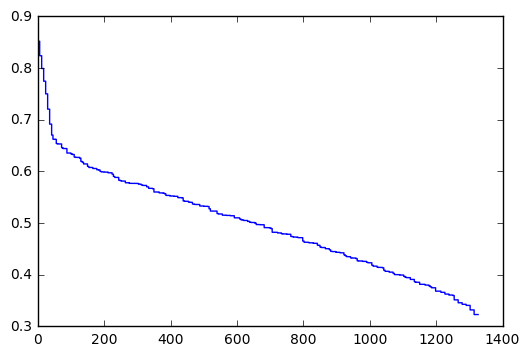

In [30]:
pfBoard = pe.string2card(['__', '__', '__', '__', '__'])
ATC = Range(1.0)
plotEqDistn(ATC, ATC, pfBoard)

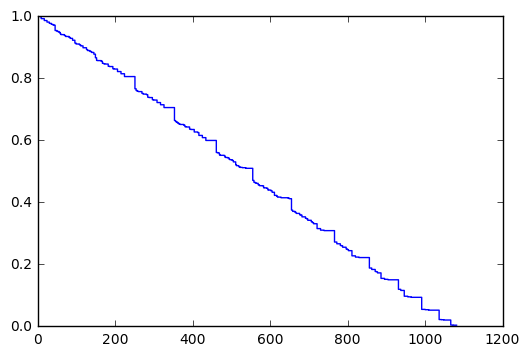

In [31]:
board2 = pe.string2card(['8d', '6s', '3h', 'Kd', 'Jd'])
range1 = Range(1.0)
range2 = Range(1.0)
plotEqDistn(range1, range2, board2)

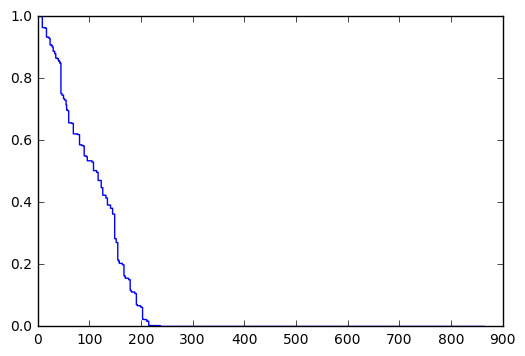

In [32]:
range1.setToTop(0.2, board2)
range2.setToTop(0.8, board2)
plotEqDistn(range2, range1, board2)

In [47]:
# Input: 
#  r1 and r2 - Ranges
#  n - positive integer
# Output: N/A
# Side-effect:
#   Modifies r1 to incorporate some amount of r2.  In particular, the fraction of every hand in r1 at
#   the end of the function will be (old amount) * (fraction) + (new amount) * (1-fraction)
#   where fraction becomes closer to 1 the higher n is.
def updateRange(r1, r2, n):
    fraction = 1 - (1 / (n + 2.0)) # Better if the fraction here is never exactly 0 or exactly 1
    for i in range(numCards):
        for j in range(i+1, numCards):
            hand = [i, j]
            r1.setFrac(hand, (r1.getFrac(hand)) * (fraction) + (r2.getFrac(hand)) * (1-fraction))

In [58]:
# Solving the shove/fold:
# SB can either shove or fold at his first decision
# SB's strategy is defined by his jamming range, and the BB's by his calling range

# Fictitious play

# Input: N/A
# Outputs: N/A
# Side-effects: display SB shoving range and BB calling range
def doShoveFoldGame():
    nIter = 200 # Number of iterations
    S = 10 # stack size in BBs
    ea = EquityArray(pe.string2card(['__','__','__','__','__']))
    
    # guess some initial ranges
    sbJamRange = Range()
    sbJamRange.setAllFracs(0.5)
    bbCallRange = Range()
    bbCallRange.setAllFracs(0.5)
    
    for n in range(nIter):
        # solve for the SB max expl strat
        bestSBJamRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i,j]
                bb_call_freq = bbCallRange.getNumHandsWithoutConflicts(hand) / numVillainHands
                equity = getEquityVsRange(hand, bbCallRange, ea)
                evJam = (1 - bb_call_freq) * (S+1) + (bb_call_freq) * equity * 2*S
                evFold = S - 0.5
                if (evJam > evFold):
                    bestSBJamRange.setFrac(hand, 1)
                else:
                    bestSBJamRange.setFrac(hand, 0)
        
        # update the SB strategy
        updateRange(sbJamRange, bestSBJamRange, n)
        
        # solve for BB max expl strat
        bestBBCallRange = Range()
        for i in range(numCards):
            for j in range(i+1, numCards):
                hand = [i, j]
                equity = getEquityVsRange(hand, sbJamRange, ea)
                evCall = 2 * S * equity
                evFold = S - 1
                if (evCall > evFold):
                    bestBBCallRange.setFrac(hand, 1)
                else:
                    bestBBCallRange.setFrac(hand, 0)
        # update BB strat
        updateRange(bbCallRange, bestBBCallRange, n)    
        
    display(sbJamRange)
    display(bbCallRange)

In [59]:
doShoveFoldGame()